In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from pinnfem import (
    Circ,
    Rect,
    plot_geo,
    exclude_points_in_region,
    plot_prediction,
    get_vals_of_points,
    wrap_to_mesh,
    plot_test_points,
    solve,
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

2024-11-11 14:07:50.263957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 14:07:50.885346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
solve_BC = {
    "bc": "default",
    "mat": "air",
    "mat_perm": 1,
    "pot_val": 0,
}
Ω = Rect(-1, -1, 2, 2, BC=solve_BC)

solve_BC_Γ1 = {"bc": "bc_plate1", "mat": "el_mat", "mat_perm": 5.0, "pot_val": 1}
Γ1 = Circ(-0.5, 0, 0.2, BC=solve_BC_Γ1)

solve_BC_Γ2 = {"bc": "bc_plate2", "mat": "el_mat", "mat_perm": 5.0, "pot_val": -1}
Γ2 = Circ(0.5, 0.2, 0.1, BC=solve_BC_Γ2)

Got a list of 3 geometries.


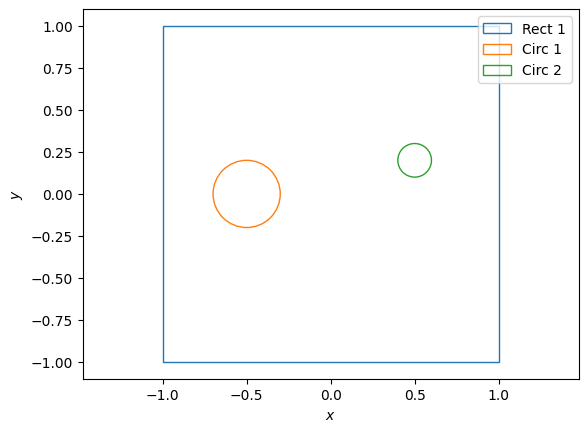

In [3]:
plot_geo([Ω, Γ1, Γ2])

In [4]:
dΓ1_pts = Γ1.generate_edge_points(n_pts=5_000)
dΓ2_pts = Γ2.generate_edge_points(n_pts=5_000)
dΓ_pts = np.vstack((dΓ1_pts, dΓ2_pts))

sΩ_pts = Ω.generate_surface_points(n_pts=15000)
sΩ_pts = exclude_points_in_region(sΩ_pts, [Γ1, Γ2])
dΩ_pts = Ω.generate_edge_points(n_pts=5_000)

print(dΓ1_pts.shape, dΓ2_pts.shape, dΩ_pts.shape, sΩ_pts.shape)

Got a list of 2 geometries to exclude.
(5000, 2) (5000, 2) (5000, 2) (14429, 2)


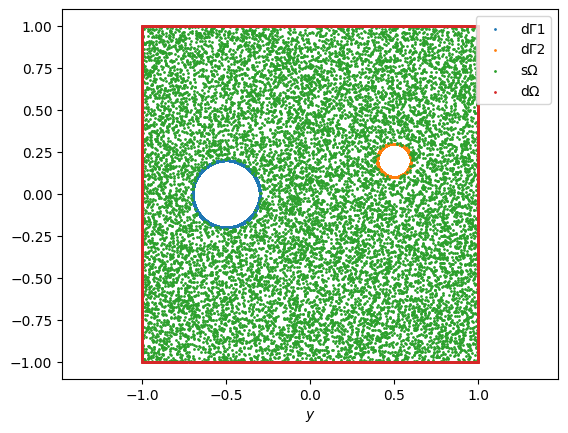

In [5]:
plt.scatter(dΓ1_pts[:, 0], dΓ1_pts[:, 1], s=1, label="dΓ1")
plt.scatter(dΓ2_pts[:, 0], dΓ2_pts[:, 1], s=1, label="dΓ2")
plt.scatter(sΩ_pts[:, 0], sΩ_pts[:, 1], s=1, label="sΩ")
plt.scatter(dΩ_pts[:, 0], dΩ_pts[:, 1], s=1, label="dΩ")
plt.xlabel("$x$")
plt.xlabel("$y$")
plt.axis("equal")
plt.legend()
plt.show()

**Train PINN**

2024-11-11 14:08:29.901602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-11-11 14:08:30.405137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 69339 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0a:00.0, compute capability: 8.0


(14429, 2) (15000, 2) (15000,)


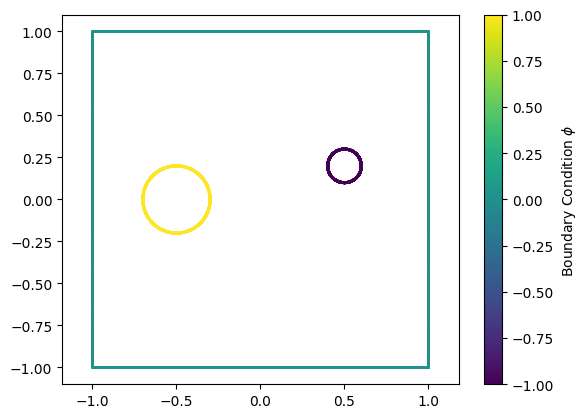

In [6]:
# TBD: write function for automatic BCs
X_b = np.concatenate((dΩ_pts, dΓ1_pts, dΓ2_pts))
y_b = np.concatenate(
    (
        np.zeros(dΩ_pts.shape[0]),
        np.ones(dΓ1_pts.shape[0]) * solve_BC_Γ1["pot_val"],
        np.ones(dΓ2_pts.shape[0]) * solve_BC_Γ2["pot_val"],
    )
)
assert X_b.shape[0] == y_b.shape[0]
shffls_idx = np.random.permutation(y_b.shape[0])

X = X_b[shffls_idx]
y = y_b[shffls_idx]

Pts = tf.constant(sΩ_pts, dtype=tf.float32)
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

print(Pts.shape, X.shape, y.shape)

X_f, X_b, y_b = Pts, X, y

plt.scatter(X_b[:, 0], X_b[:, 1], c=y_b, s=1)
plt.axis("equal")
plt.colorbar(label="Boundary Condition $\phi$")
plt.show()

In [7]:
class PINN(tf.keras.Model):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = []
        for width in layers[:-1]:
            self.hidden_layers.append(tf.keras.layers.Dense(width, activation="tanh"))
        self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None)

    def call(self, X):
        x = X
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)


# PDE residual function: Laplace's equation (Delta u = 0)
def pde_residual(model, interior_points):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(interior_points)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(interior_points)
            u_pred = model(interior_points)
        u_x = tape.gradient(u_pred, interior_points)[:, 0:1]
        u_y = tape.gradient(u_pred, interior_points)[:, 1:2]
    u_xx = tape2.gradient(u_x, interior_points)[:, 0:1]
    u_yy = tape2.gradient(u_y, interior_points)[:, 1:2]
    del tape, tape2
    return u_xx + u_yy  # Laplacian u_xx + u_yy = 0


def compute_loss(
    model,
    interior_points,
    outer_boundary_points,
    outer_boundary_values,
    electrode_boundary_points,
    electrode_boundary_values,
):
    pde_loss = tf.reduce_mean(tf.square(pde_residual(model, interior_points)))

    u_outer_pred = model(outer_boundary_points)
    outer_bc_loss = tf.reduce_mean(tf.square(u_outer_pred - outer_boundary_values))

    u_electrode_pred = model(electrode_boundary_points)
    electrode_bc_loss = tf.reduce_mean(
        tf.square(u_electrode_pred - electrode_boundary_values)
    )

    total_loss = pde_loss + outer_bc_loss + electrode_bc_loss
    return total_loss


# @tf.function
def train_pinn(
    model,
    interior_points,
    outer_boundary_points,
    electrode_boundary_points,
    epochs,
    lr=1e-3,
):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    outer_boundary_values = tf.zeros((outer_boundary_points.shape[0], 1))
    electrode_boundary_values = tf.ones((electrode_boundary_points.shape[0], 1))

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = compute_loss(
                model,
                interior_points,
                outer_boundary_points,
                outer_boundary_values,
                electrode_boundary_points,
                electrode_boundary_values,
            )
            Loss.append(loss)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 100 == 0:
            tf.print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")


# Sampling
interior_points = X_f
outer_boundary_points = dΩ_pts
electrode_boundary_points = dΓ_pts

# Convert to TensorFlow tensors
interior_points = tf.convert_to_tensor(interior_points, dtype=tf.float32)
outer_boundary_points = tf.convert_to_tensor(outer_boundary_points, dtype=tf.float32)
electrode_boundary_points = tf.convert_to_tensor(
    electrode_boundary_points, dtype=tf.float32
)

# Build and train the PINN model
layers = [2, 40, 40, 40, 40, 40, 40, 40, 28, 1]
pinn_model = PINN(layers)

Loss = list()
# Train the PINN
train_pinn(
    pinn_model,
    interior_points,
    outer_boundary_points,
    electrode_boundary_points,
    epochs=50_000,
    lr=1e-3,
)

Epoch 0, Loss: 1.052531
Epoch 100, Loss: 0.476767
Epoch 200, Loss: 0.472765
Epoch 300, Loss: 0.465568
Epoch 400, Loss: 0.462442
Epoch 500, Loss: 0.459813
Epoch 600, Loss: 0.454795
Epoch 700, Loss: 0.447132
Epoch 800, Loss: 0.438972
Epoch 900, Loss: 0.427941
Epoch 1000, Loss: 0.421538
Epoch 1100, Loss: 0.416247
Epoch 1200, Loss: 0.408444
Epoch 1300, Loss: 0.577703
Epoch 1400, Loss: 0.374308
Epoch 1500, Loss: 0.238047
Epoch 1600, Loss: 0.217753
Epoch 1700, Loss: 0.190918
Epoch 1800, Loss: 0.189543
Epoch 1900, Loss: 0.186531
Epoch 2000, Loss: 0.186466
Epoch 2100, Loss: 0.184934
Epoch 2200, Loss: 0.183492
Epoch 2300, Loss: 0.183367
Epoch 2400, Loss: 0.183469
Epoch 2500, Loss: 0.183403
Epoch 2600, Loss: 0.184018
Epoch 2700, Loss: 0.182189
Epoch 2800, Loss: 0.181663
Epoch 2900, Loss: 0.182892
Epoch 3000, Loss: 0.182219
Epoch 3100, Loss: 0.180966
Epoch 3200, Loss: 0.181475
Epoch 3300, Loss: 0.182222
Epoch 3400, Loss: 0.180712
Epoch 3500, Loss: 0.184638
Epoch 3600, Loss: 0.180849
Epoch 3700, L

In [8]:
pinn_model.save("models/2d_electode_circ_circ.keras")

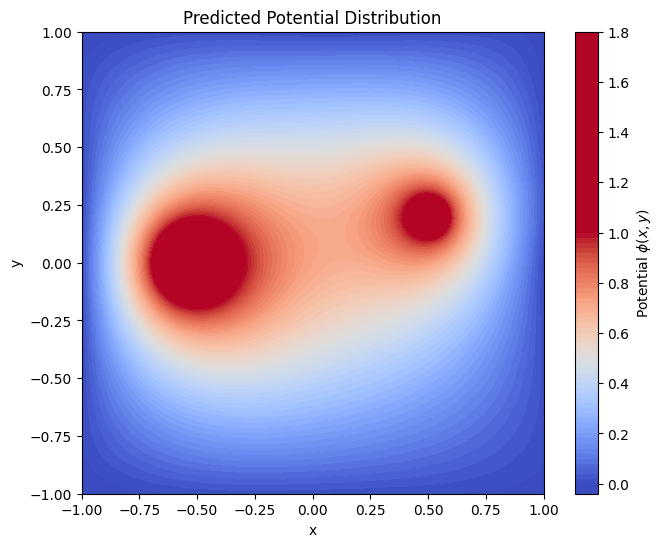

In [27]:
X, Y, grid_points = Ω.generate_grid()

grid_points_tf = tf.convert_to_tensor(grid_points, dtype=tf.float32)
u_pred = pinn_model(grid_points_tf)
u_pred = u_pred.numpy()

plot_prediction(X, Y, u_pred)

**FEM solution**

Got a list of 3 geometries.


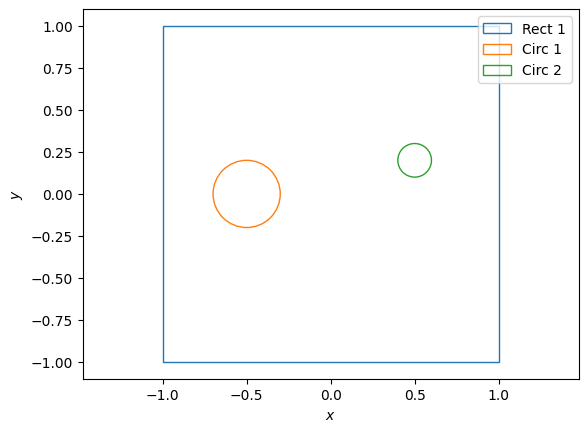

In [28]:
plot_geo([Ω, Γ1, Γ2])  # plate3

In [29]:
refinement = 0.05
mesh = wrap_to_mesh(Ω, [Γ1, Γ2], refinement)
# solve and get grid function
gfu = solve(Ω, [Γ1, Γ2], refinement)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [31]:
X, Y, Pts = Ω.generate_grid()
# Pts = exclude_points_in_region(sΩ_pts, [Γ1, Γ2])

xs, ys, vals = get_vals_of_points(mesh, gfu, Pts)

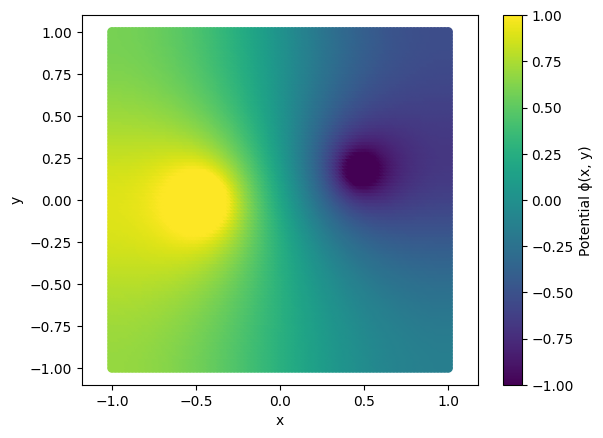

In [32]:
plot_test_points(xs, ys, vals)

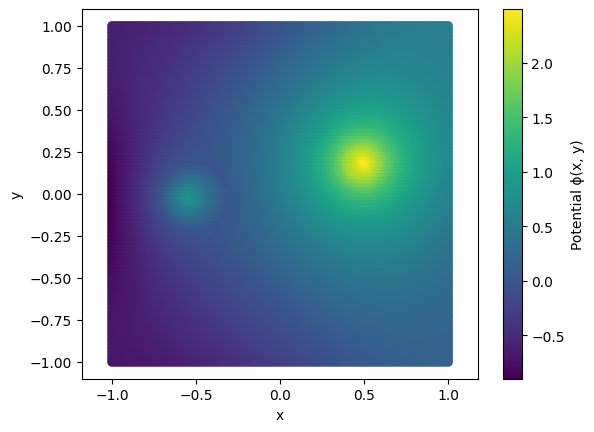

In [39]:
plot_test_points(xs, ys, u_pred[:, 0] - vals)